<a href="https://colab.research.google.com/github/hannakb/Neurons-Importance/blob/master/convolution_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%cd 'gdrive/My Drive/Neuron Importance/cnn_with_my_utils'

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# from tqdm.notebook as tqdm
from  tqdm import tqdm_notebook as tqdm
from tqdm import trange

%matplotlib inline

In [0]:
from my_utilities import StatsOneLayer, load_data, train_epoch, calc_acc, prune_layer

In [6]:
train_loader, valid_loader, test_loader = load_data('CIFAR10')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model = nn.Sequential(
    nn.Conv2d(3, 32, 3), 
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, 3), 
    nn.ReLU(),
    nn.Conv2d(32, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout2d(p=0.5),
    Flatten(),
    nn.Linear(800, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax(-1)
)
intermediate_layers = [1, 3, 6, 8, 13]

In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# n_layers x 3 metrics x n_epoch (it appended)
stats = [[[] for _ in range(3)] for _ in intermediate_layers]
train_accuracy = []
valid_accuracy = []
model = model.cuda()

In [0]:
n_epoch = 200
for ep_ind in trange(n_epoch):
    # print("Epoch {} / {}".format(ep_ind + 1, n_epoch))
    model.train()
    train_epoch(model, train_loader, optimizer, criterion, device='cuda')
    model.eval()
    for ind, layer_ind in enumerate(intermediate_layers):
        curr_stats = StatsOneLayer(model[:layer_ind + 1], 10, valid_loader, device='cuda')
        stats[ind][0].append(curr_stats.entropy)
        stats[ind][1].append(curr_stats.mi)
        stats[ind][2].append(curr_stats.kl)
    train_accuracy.append(calc_acc(model, train_loader, 'cuda'))
    valid_accuracy.append(calc_acc(model, valid_loader, 'cuda'))
    print("Train accuracy {}, validation accuracy {}".format(
        train_accuracy[-1], valid_accuracy[-1]))

In [0]:
import pickle
# with open('cnn_cifar_model.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#     pickle.dump([model.state_dict(), stats], f)

with open('cnn_cifar_model.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    model_sd, stats = pickle.load(f)

In [9]:
model.load_state_dict(model_sd)
model = model.cuda()

<All keys matched successfully>

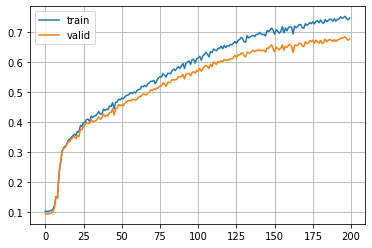

In [44]:
plt.plot(train_accuracy, label='train')
plt.plot(valid_accuracy, label='valid')
plt.legend()
plt.grid()

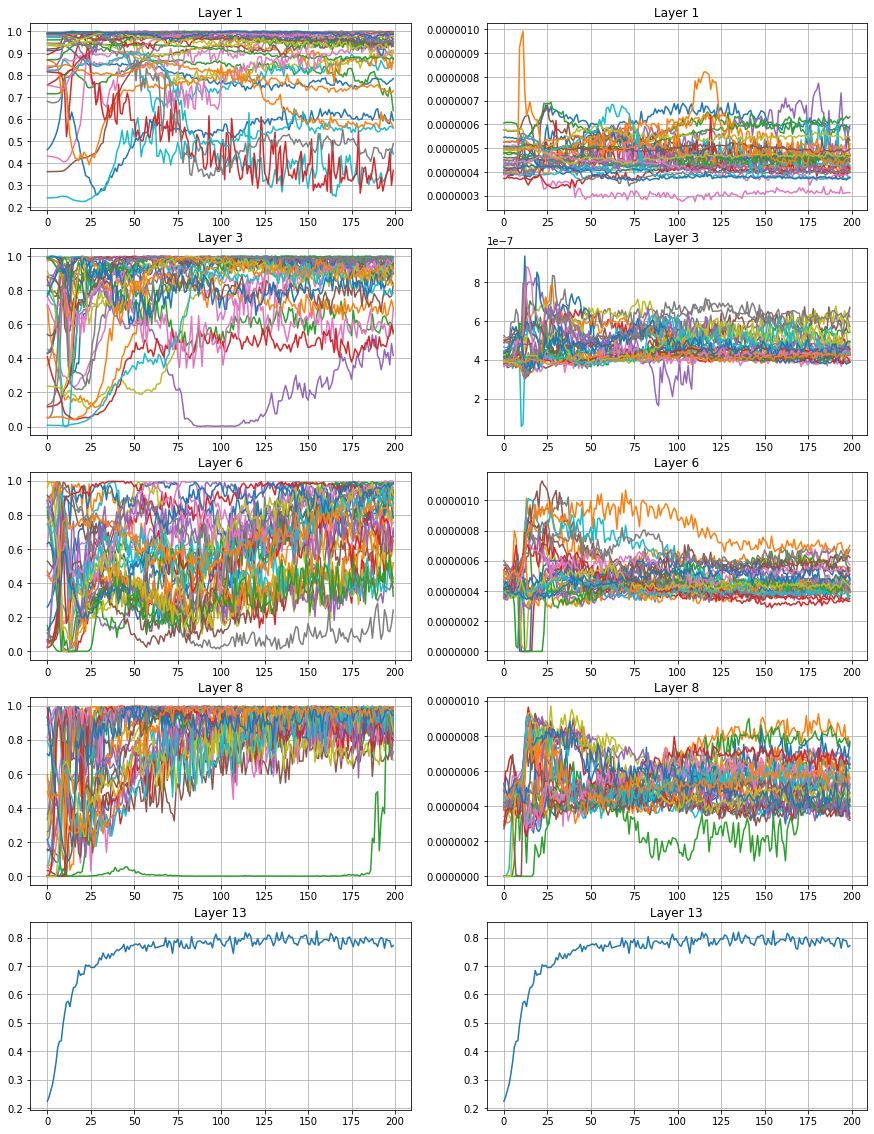

In [64]:
plt.figure(figsize=(15,20))
for i in range(4):
    plt.subplot(5, 2, i*2 + 1)
    plt.plot(np.mean(stats[i][0], -1).mean(-1), label='entropy')
    plt.title("Layer {}".format(intermediate_layers[i]))
    plt.grid()
    plt.subplot(5, 2, i*2 + 2)
    plt.plot(np.mean(stats[i][1], -1).mean(-1), label='kl')
    plt.title("Layer {}".format(intermediate_layers[i]))
    plt.grid()

i = 4
plt.subplot(5, 2, i*2 + 1)
plt.plot(np.mean(stats[i][0], -1), label='entropy')
plt.title("Layer {}".format(intermediate_layers[i]))
plt.grid()
plt.subplot(5, 2, i*2 + 2)
plt.plot(np.mean(stats[i][0], -1), label='kl')
plt.title("Layer {}".format(intermediate_layers[i]))
plt.grid()

Ablating layers

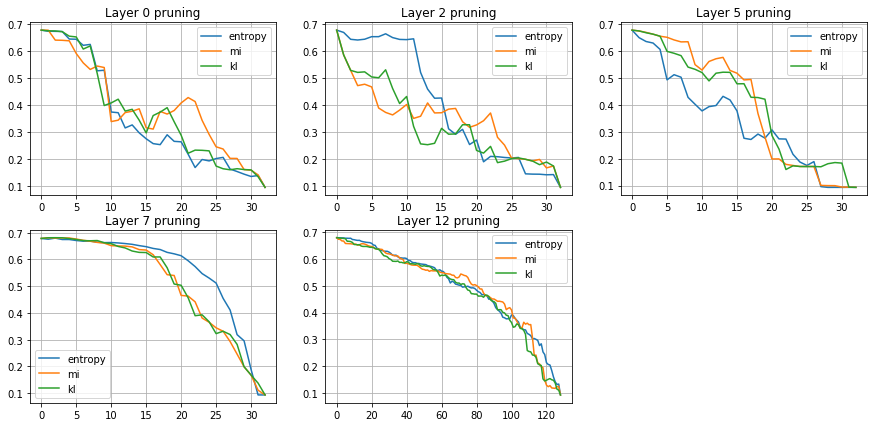

In [125]:
from copy import deepcopy
plt.figure(figsize=(15,7))
for i in range(4):
    plt.subplot(2, 3, i + 1)
    plt.title("Layer {} pruning".format(intermediate_layers[i] - 1))
    pruned_model = deepcopy(model)
    pruning_acc = prune_layer(pruned_model, pruned_model[intermediate_layers[i] - 1],
                             np.argsort(stats[i][0][-1].mean(-1).mean(-1)), valid_loader)
    plt.plot(pruning_acc, label='entropy')
    pruned_model = deepcopy(model)
    pruning_acc = prune_layer(pruned_model, pruned_model[intermediate_layers[i] - 1],
                             np.argsort(stats[i][1][-1].mean(-1).mean(-1)), valid_loader)
    plt.plot(pruning_acc, label='mi')
    pruned_model = deepcopy(model)
    pruning_acc = prune_layer(pruned_model, pruned_model[intermediate_layers[i] - 1],
                             np.argsort(stats[i][2][-1].mean(-1).mean(-1).max(-1)), valid_loader)
    plt.plot(pruning_acc, label='kl')
    plt.grid()
    plt.legend()
i = 4
plt.subplot(2, 3, i + 1)
plt.title("Layer {} pruning".format(intermediate_layers[i] - 1))
pruned_model = deepcopy(model)
pruning_acc = prune_layer(pruned_model, pruned_model[intermediate_layers[i] - 1],
                         np.argsort(stats[i][0][-1]), valid_loader)
plt.plot(pruning_acc, label='entropy')
pruned_model = deepcopy(model)
pruning_acc = prune_layer(pruned_model, pruned_model[intermediate_layers[i] - 1],
                         np.argsort(stats[i][1][-1]), valid_loader)
plt.plot(pruning_acc, label='mi')
pruned_model = deepcopy(model)
pruning_acc = prune_layer(pruned_model, pruned_model[intermediate_layers[i] - 1],
                         np.argsort(stats[i][2][-1].max(-1)), valid_loader)
plt.plot(pruning_acc, label='kl')
plt.grid()
plt.legend()

